# 03 - Full-Waveform Inversion (FWI)

This notebook is the third in a series of tutorial highlighting various aspects of seismic inversion based on Devito operators. In this second example we aim to highlight the core ideas behind seismic inversion, where we create an image of the subsurface from field recorded data. This tutorial follows on the modelling tutorial and will reuse the modelling and velocity model.

## Inversion requirement

Seismic inversion relies on two known parameters:

- **Field data** - or also called **recorded data**. This is a shot record corresponding to the true velocity model. In practice this data is acquired as described in the first tutorial. In order to simplify this tutorial we will fake field data by modelling it with the true velocity model.

- **Initial velocity model**. This is a velocity model that has been obtained by processing the field data. This model is a rough and very smooth estimate of the velocity as an initial estimate for the inversion. This is a necessary requirement for any optimization (method).

## Inversion computational setup

In this tutorial, we will introduce the gradient operator. This operator corresponds to the imaging condition introduced in the previous tutorial with some minor modifications that are defined by the objective function and its derivative. We will define this two terms in the tutorial too.

## Notes on the operators

As we already describe the creation of a forward modelling operator, we will only call an wraped function here. This wrappers already contains all the necessary operator for seismic modeling, imaging and inversion, however any new operator will be fully described and only used from the wrapper in the next tutorials.

In [1]:
import numpy as np
%matplotlib inline

from devito import configuration
configuration['log_level'] = 'WARNING'

## Computational considerations

As we will see in this tutorial, FWI is again very computationally demanding, even more so than RTM. To keep this tutorial as light-wight as possible we therefore again use a very small demonstration model. We also define here a few parameters for the final example runs that can be changed to modify the overall runtime of the tutorial.

In [2]:
nshots = 2  # Number of shots to create gradient from
nreceivers = 101  # Number of receiver locations per shot 
fwi_iterations = 8  # Number of outer FWI iterations

# True and smooth velocity models

As before, we will again use a very simple model domain, consisting of a circle within a 2D domain. We will again use the "true" model to generate our synthetic shot data and use a "smooth" model as our initial guess. In this case the smooth model is very smooth indeed - it is simply a constant background velocity without any features.

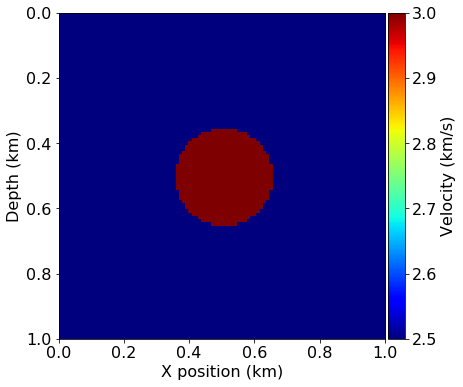

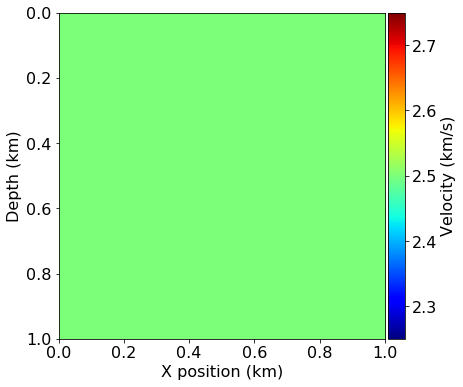

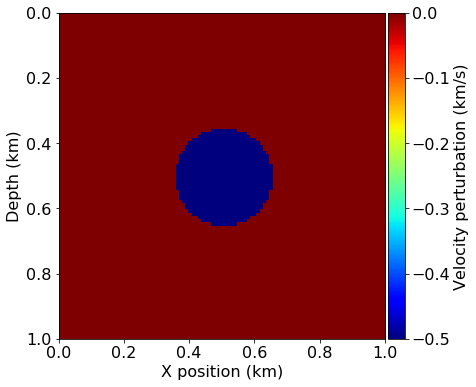

In [3]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import demo_model, plot_velocity, plot_perturbation

# Define true and initial model
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # Need origin to define relative source and receiver locations

model = demo_model('circle-isotropic', vp=3.0, vp_background=2.5,
                    origin=origin, shape=shape, spacing=spacing, nbpml=40)

model0 = demo_model('circle-isotropic', vp=2.5, vp_background=2.5,
                     origin=origin, shape=shape, spacing=spacing, nbpml=40)

plot_velocity(model)
plot_velocity(model0)
plot_perturbation(model0, model)

## Acquisition geometry

In this tutorial, we will use the easiest case for inversion, namely a transmission experiment. The sources are located on one side of the model and the receivers on the other side. This allow to record most of the information necessary for inversion, as reflections usually lead to poor inversion results.

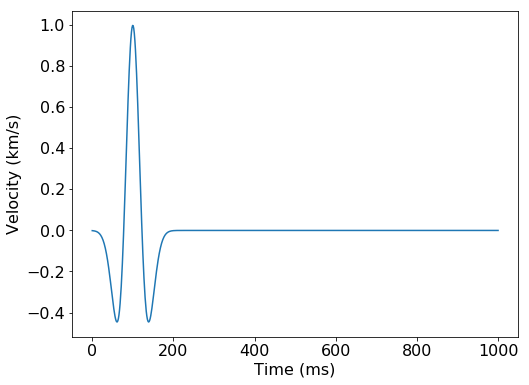

In [4]:
#NBVAL_IGNORE_OUTPUT
# Define acquisition geometry: source
from examples.seismic import RickerSource, Receiver

# Define time discretization according to grid spacing
t0 = 0.
tn = 1000.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt  # Time step from model grid spacing
nt = int(1 + (tn-t0) / dt)  # Discrete time axis length
time = np.linspace(t0, tn, nt)  # Discrete modelling time

f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0, time=np.linspace(t0, tn, nt))
src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.coordinates.data[0, 0] = 20.  # 20m from the left end

# We can plot the time signature to see the wavelet
src.show()

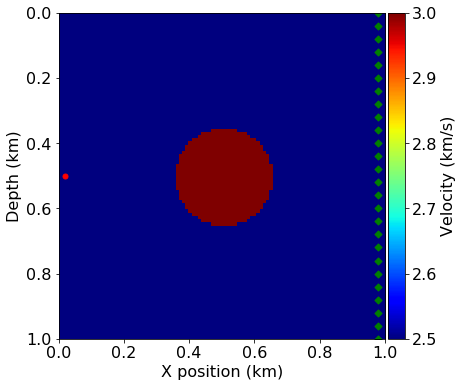

In [5]:
#NBVAL_IGNORE_OUTPUT
# Define acquisition geometry: receivers

# Initialize receivers for synthetic data
rec = Receiver(name='rec', grid=model.grid, npoint=nreceivers, ntime=nt)
rec.coordinates.data[:, 1] = np.linspace(0, model.domain_size[0], num=nreceivers)
rec.coordinates.data[:, 0] = 980. # 20m from the right end

# Plot acquisition geometry
plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])

## True and smooth data

We can generate shot records for the true and smoothed initial velocity models, since the difference between them will again form the basis of our imaging procedure.

In [6]:
# Compute synthetic data with forward operator 
from examples.seismic.acoustic import AcousticWaveSolver

solver = AcousticWaveSolver(model, src, rec, space_order=4)
true_d, _, _ = solver.forward(src=src, m=model.m)

In [7]:
# Compute initial data with forward operator 
smooth_d, _, _ = solver.forward(src=src, m=model0.m)

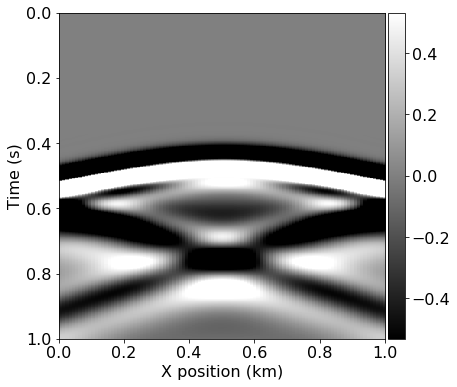

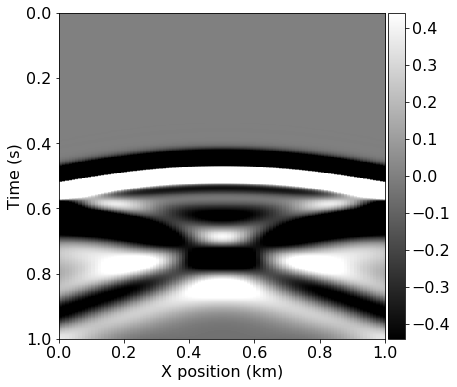

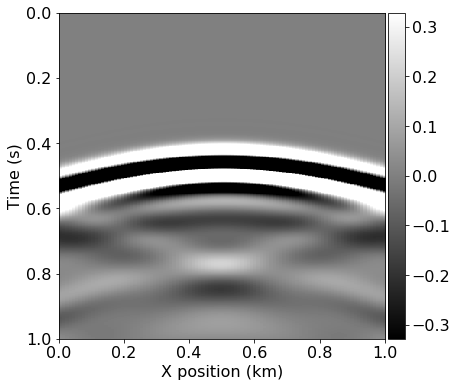

In [8]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

# Plot shot record for true and smooth velocity model and the difference
plot_shotrecord(true_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn)

# Full-Waveform Inversion


## Formulation

Full-waveform inversion (FWI) aims to invert an accurate model of the discrete wave velocity, $\mathbf{c}$, or equivalently the square slowness of the wave, $\mathbf{m} = \frac{1}{\mathbf{c}^2}$, from a given set of measurements of the pressure wavefield $\mathbf{u}$. This can be expressed as the following optimization problem [1, 2]:

\begin{aligned}
	\mathop{\hbox{minimize}}_{\mathbf{m}} \Phi_s(\mathbf{m})&=\frac{1}{2}\left\lVert\mathbf{P}_r
	\mathbf{u} - \mathbf{d}\right\rVert_2^2 \\
	\mathbf{u} &= \mathbf{A}(\mathbf{m})^{-1} \mathbf{P}_s^T \mathbf{q}_s, 
\end{aligned}

where $\mathbf{P}_r$ is the sampling operator at the receiver locations, $\mathbf{P}_s^T$ is the injection operator at the source locations, $\mathbf{A}(\mathbf{m})$ is the operator representing the discretized wave equation matrix, $\mathbf{u}$ is the discrete synthetic pressure wavefield, $\mathbf{q}_s$ is the corresponding pressure source and $\mathbf{d}$ is the measured data. It is worth noting that $\mathbf{m}$ is the unknown in this formulation and that multiple implementations of the wave equation operator $\mathbf{A}(\mathbf{m})$ are possible. 

We have already defined a concrete solver scheme for $\mathbf{A}(\mathbf{m})$ in the first tutorial, including appropriate implementations of the sampling operator $\mathbf{P}_r$ and source term $\mathbf{q}_s$.

To solve this optimization problem using a gradient-based method, we use the
adjoint-state method to evaluate the gradient $\nabla\Phi_s(\mathbf{m})$:

\begin{align}
 \nabla\Phi_s(\mathbf{m})=\sum_{\mathbf{t} =1}^{n_t}\mathbf{u}[\mathbf{t}] \mathbf{v}_{tt}[\mathbf{t}] =\mathbf{J}^T\delta\mathbf{d}_s,
\end{align}

where $n_t$ is the number of computational time steps, $\delta\mathbf{d}_s = \left(\mathbf{P}_r \mathbf{u} - \mathbf{d} \right)$ is the data residual (difference between the measured data and the modelled data), $\mathbf{J}$ is the Jacobian operator and $\mathbf{v}_{tt}$ is the second-order time derivative of the adjoint wavefield solving:

\begin{align}
 \mathbf{A}^T(\mathbf{m}) \mathbf{v} = \mathbf{P}_r^T \delta\mathbf{d}.
\end{align}

We see that the gradient of the FWI function is the previously defined imaging condition with an extra second-order time derivative. We will therefore reuse the operators defined previously inside a Devito wrapper.

## FWI gradient operator

To compute a single gradient $\nabla\Phi_s(\mathbf{m})$ in our optimization workflow we again use `solver.forward` to compute the entire forward wavefield $\mathbf{u}$ and a similar pre-defined gradient operator to compute the adjoint wavefield `v`. The gradient operator provided by our `solver` utility also computes the correlation between the wavefields, allowing us to encode a similar procedure to the previous imaging tutorial as our gradient calculation:

- Simulate the forward wavefield with the background velocity model to get the synthetic data and save the full wavefield $\mathbf{u}$
- Compute the data residual
- Back-propagate the data residual and compute on the fly the gradient contribution at each time step. 

This procedure is applied to multiple source positions and summed to obtain a gradient image of the subsurface. We again prepare the source locations for each shot and visualize them, before defining a single gradient computation over a number of shots as a single function.

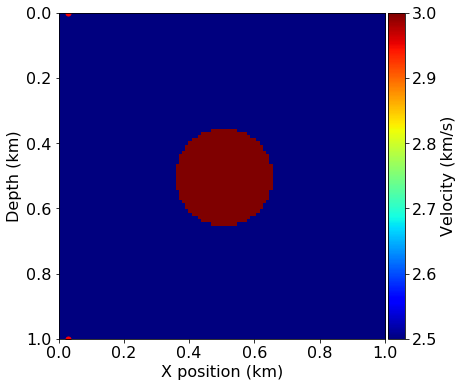

In [9]:
#NBVAL_IGNORE_OUTPUT

# Prepare the varying source locations sources
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = 30.
source_locations[:, 1] = np.linspace(0., 1000, num=nshots)

plot_velocity(model, source=source_locations)

In [10]:
# Create FWI gradient kernel 
from devito import Function, clear_cache

def fwi_gradient(m_in):
    # Important: We force previous wavefields to be destroyed,
    # so that we may reuse the memory.
    clear_cache()
    
    # Create symbols to hold the gradient and residual
    grad = Function(name="grad", grid=model.grid)
    residual = Receiver(name='rec', grid=model.grid,
                        ntime=nt, coordinates=rec.coordinates.data)
    objective = 0.
    
    for i in range(nshots):
        # Update source location
        src.coordinates.data[0, :] = source_locations[i, :]
        
        # Generate synthetic data from true model
        true_d, _, _ = solver.forward(src=src, m=model.m)
        
        # Compute smooth data and full forward wavefield u0
        smooth_d, u0, _ = solver.forward(src=src, m=m_in, save=True)
        
        # Compute gradient from data residual and update objective function 
        residual.data[:] = smooth_d.data[:] - true_d.data[:]
        objective += .5*np.linalg.norm(residual.data.reshape(-1))**2
        solver.gradient(rec=residual, u=u0, m=m_in, grad=grad)
    
    return objective, grad.data

Having defined our FWI gradient procedure we can compute the initial iteration from our starting model. This allows us to visualize the gradient alongside the model perturbation and the effect of the gradient update on the model.

In [11]:
#NBVAL_IGNORE_OUTPUT

# Compute gradient of initial model
ff, update = fwi_gradient(model0.m)
print('Objective value is %f ' % ff)

Objective value is 8123.404723 


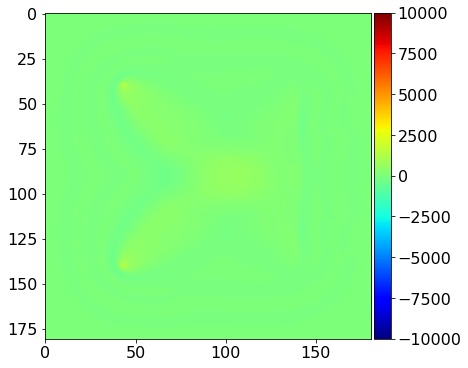

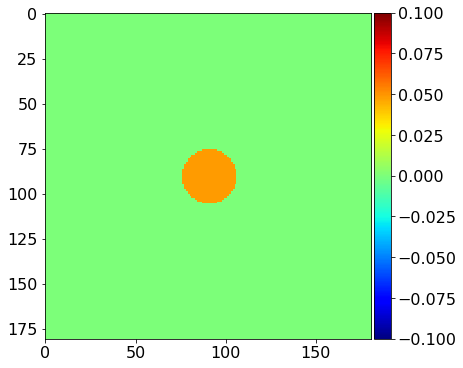

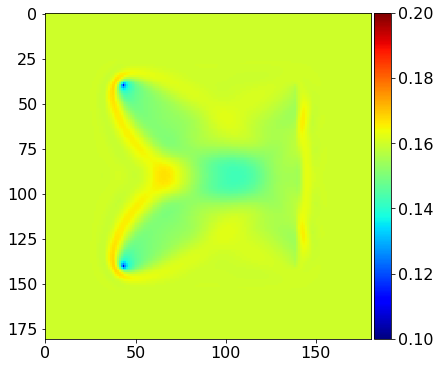

In [12]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_image

# Plot the FWI gradient
plot_image(update, vmin=-1e4, vmax=1e4, cmap="jet")

# Plot the difference between the true and initial model.
# This is not known in practice as only the initial model is provided.
plot_image(model0.m.data - model.m.data, vmin=-1e-1, vmax=1e-1, cmap="jet")

# Show what the update does to the model
alpha = .05 / np.max(update)
plot_image(model0.m.data - alpha*update, vmin=.1, vmax=.2, cmap="jet")

We see that the gradient and the true perturbation have the same sign, therefore, with an appropriate scaling factor, we will update the model in the correct direction.

In [13]:
# Create bounds constraint
def bound_constr(m):
    m[m<.08] = .08 # Maximum accepted velocity is 3.5 km/sec (true is 3 km/sec)
    m[m>.25] = .25 # Minimum accepted velocity is 2 km/sec (true is 2.5 km/sec)
    return m

In [14]:
#NBVAL_SKIP

# Run FWI with gradient descent
history = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
    # Compute the functional value and gradient for the current
    # model estimate
    phi, direction = fwi_gradient(model0.m)
    
    # Store the history of the functional values
    history[i] = phi
    
    # Artificial Step length for gradient descent
    # In practice this would be replaced by a Linesearch (Wolfe, ...)
    # that would guarantee functional decrease Phi(m-alpha g) <= epsilon Phi(m)
    # where epsilon is a minimum decrease constant
    alpha = .005 / np.max(direction)
    
    # Update the model estimate and inforce minimum/maximum values
    model0.m.data[:] = bound_constr(model0.m.data - alpha * direction)
    
    # Log the progress made
    print('Objective value is %f at iteration %d' % (phi, i+1))

Objective value is 8123.404723 at iteration 1
Objective value is 6619.127235 at iteration 2
Objective value is 5250.698110 at iteration 3
Objective value is 3988.452039 at iteration 4
Objective value is 2730.633283 at iteration 5
Objective value is 1601.427124 at iteration 6
Objective value is 883.630666 at iteration 7
Objective value is 481.523904 at iteration 8


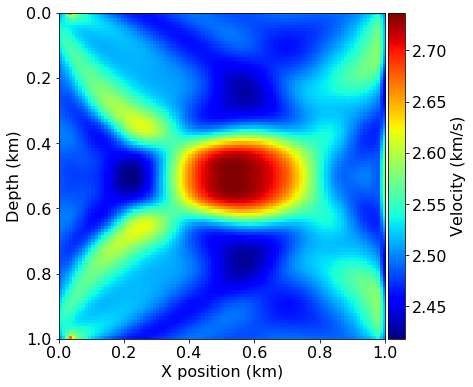

In [15]:
#NBVAL_IGNORE_OUTPUT

# First, update velocity from computed square slowness
nbpml = model.nbpml
model0.vp = np.sqrt(1. / model0.m.data[nbpml:-nbpml, nbpml:-nbpml])

# Plot inverted velocity model
plot_velocity(model0)

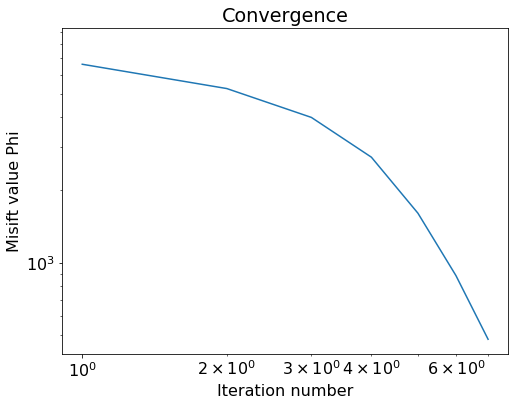

In [16]:
#NBVAL_SKIP
import matplotlib.pyplot as plt

# Plot objective function decrease
plt.figure()
plt.loglog(history)
plt.xlabel('Iteration number')
plt.ylabel('Misift value Phi')
plt.title('Convergence')
plt.show()

## References

[1] _Virieux, J. and Operto, S.: An overview of full-waveform inversion in exploration geophysics, GEOPHYSICS, 74, WCC1–WCC26, doi:10.1190/1.3238367, http://library.seg.org/doi/abs/10.1190/1.3238367, 2009._

[2] _Haber, E., Chung, M., and Herrmann, F. J.: An effective method for parameter estimation with PDE constraints with multiple right hand sides, SIAM Journal on Optimization, 22, http://dx.doi.org/10.1137/11081126X, 2012._